# Grover Advanced (Satisfiability Problem)

In [1]:
# initialization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

# import algorithms from Qiskit
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle
from qiskit.compiler import transpile
from qiskit.utils import QuantumInstance

## II. Grover's Algorithm to Solve a Satisfyability Problem

Imagine you are throwing a birthday party and you need to decide which of your friends Alice, Bob, Charlie, Dave and Eve to invite. There are a few restrictions:

i) Alice and Eve are always fighting, so you definitely do not want to invite both of them.

ii) Alice and Charlie are married, so if you invite one of them, you have to invite the other one as well.

iii) In order to liven up the atmosphere, you want to invite at least one of your more entertaining friends, Bob and Dave.

iv) Whenever the three guys, Bob, Charlie and Dave, get together, they somehow incite each other and the party might get out of control. So don't invite all three of them.

v) You know that if you invite Bob, he will most likely ask Alice about ideas for a birthday present. Therefore, if you invite Bob, you should also invite Alice (but not necessarily the other way around).

vi) Dave will only come if Bob comes as well (not the other way around though). So no point to invite him if Bob is not getting invited.

Let us use Grover's algorithm to figure out which options you have for possible invite lists. For that we first need to feed this information into the oracle. To do so, let us encode the statements above as logical statements and then formulate them as a 3-SAT problem (described in detail here: https://qiskit.org/textbook/ch-applications/satisfiability-grover.html#3satproblem). Note that 3SAT problems can be always written in what is known as conjunctive normal form (CNF), which is our input to the oracle. A formula is in conjunctive normal form (CNF) if it is a conjunction of clauses (or a single clause). Each clause in the 3-SAT problem is a disjunction of at most three literals. A literal is either a variable, called positive literal, or the negation of a variable, called negative literal.

To give you an example, the first statement could be encoded as a logical statement as

$(\lnot A \land E)$.

However, this is not a clause (or a conjunction of clauses). We can rewrite it as

$\lnot A \lor E$

though, which is a disjunction of two negative literals and therefore a valid clause.
For the input to the oracle in Qiskit, we encode each clause as one line with the literals and a 0 in the end, so in this case the corresponding line would be (encoding A as 1, B as 2, C as 3, D as 4 and E as 5),

`-1 -5 0`.

Writing each of the restrictions as a clause or a conjunction of clauses, we get for the six restrictions the following seven clauses as ii) cannot be written as a single clause:

i) $\lnot A \lor \lnot E$ `-1 -5 0`

ii) $(A \lor \lnot C) \land (\lnot A \lor C)$ `-1 -3 0 ∧ -1 3 0`

iii) $B \lor D$ `2 4 0`

iv) $\lnot A \lor \lnot C \lor \lnot D$ `-2 -3 -4 0`

v) $A \lor \lnot B$ `1 -2 0`

vi) $B \lor \lnot D$ `2 -4 0`



In [2]:
# this indicates that the input is CNF with five variables and seven clauses
input_3sat = '''
c example DIMACS-CNF 3-SAT
p cnf 5 7
-1 -5 0
1 -3 0
-1 3 0
2 4 0
-2 -3 -4 0
1 -2 0
2 -4 0
'''

In [3]:
with open("3sat.dimacs", "w") as text_file:
    text_file.write(input_3sat)
    
oracle = PhaseOracle.from_dimacs_file("3sat.dimacs")

backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
problem = AmplificationProblem(oracle=oracle)

# Use Grover's algorithm to solve the problem
grover = Grover(quantum_instance=quantum_instance)
result = grover.amplify(problem)

# we're interested in the top measurement = result that has the highest 
# probability to be chosen.
result.top_measurement

# Interpretation of the result (bit string in right to left order, EDCBA): 
# we should invite Alice, Bob, Charlie (1), 
# we should not invite Dave and Eve (0).

'00111'

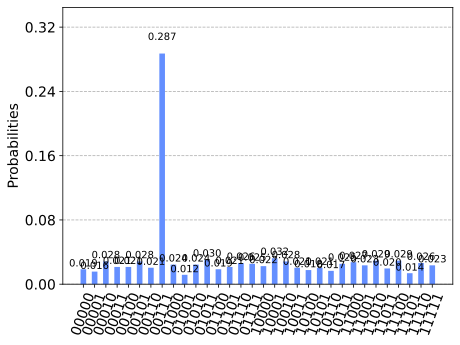

In [4]:
plot_histogram(result.circuit_results)

## Implement this on a real device

too many CNOT gates: if each of the CNOT gates has an error of approx 0.5%, then no useful result after 100 gates or so.)

__NEED BETTER DEVICES TO SOLVE SUCH PROBLEMS__

In [9]:
from qiskit.compiler import transpile

# load saved IBMQ accounts and get the ibmq_16_melbourne backend
# from qiskit.test.mock import FakeMelbourne
from qiskit.providers.fake_provider import FakeMelbourne
melbourne = FakeMelbourne()

# transpile the circuit for ibmq_16_melbourne
qc = grover.construct_circuit(problem, max(result.iterations))
qc.measure_all()
grover_compiled = transpile(qc, backend=melbourne, optimization_level=3)

print('gates = ', grover_compiled.count_ops())
print('depth = ', grover_compiled.depth())


gates =  OrderedDict([('u3', 179), ('cx', 140), ('u2', 91), ('u1', 10), ('measure', 5), ('barrier', 1)])
depth =  225


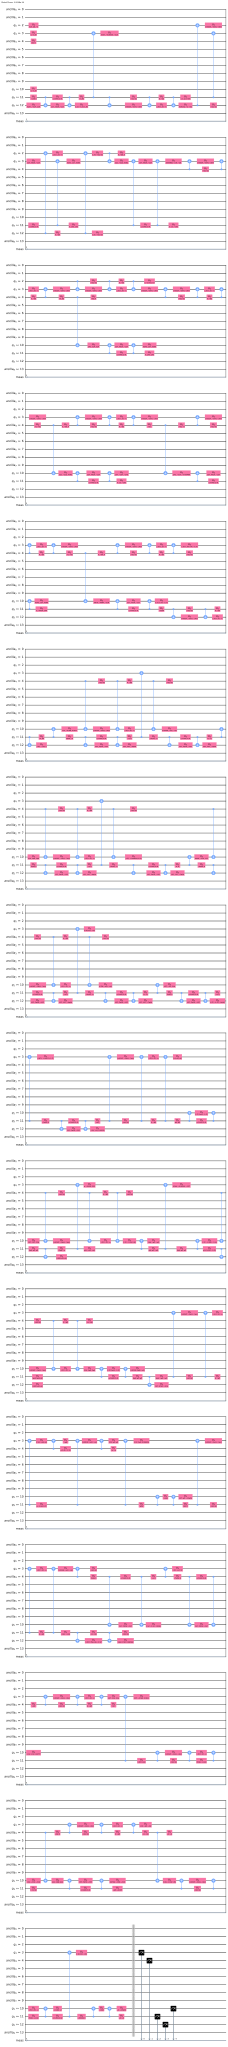

In [13]:
# it's a huge diagram
# grover_compiled.draw()